## Descrição do Desafio

Projeto de Transfer Learning em Python
O projeto consiste em aplicar o método de Transfer Learning em uma rede de Deep Learning na linguagem Python no ambiente COLAB.  

Para exemplo, utilizaremos o seguinte projeto que realiza Transfer Learning com o Dataset do MNIST:
https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb

O dataset utilizado engloba duas classes: gatos e cachorros. Uma descrição da base de dados pode ser visualizada neste link: https://www.tensorflow.org/datasets/catalog/cats_vs_dogs.

Já o dataset para download pode ser acessado por meio deste outro link:

https://www.microsoft.com/en-us/download/details.aspx?id=54765.



Observações: Neste projeto, você pode usar sua própria base de dados (exemplo: fotos suas, dos seus pais, dos seus amigos, dos seus animais domésticos, etc), o exemplo de gatos e cachorros, pode ser substituído por duas outras classes do seu interesse. O Dataset criado em nosso projeto anterior, pode ser utilizado agora.  

O projeto deve ser enviado para o GitHub da DIO: https://github.com/digitalinnovationone.

Slides
A apresentação completa utilizada neste módulo está disponível AQUI
Com isso, você terá acesso a todos os slides e links explorados durante as aulas.

O projeto consiste em aplicar o método de Transfer Learning em uma rede de Deep Learning na linguagem Python no ambiente COLAB. Neste projeto, você pode usar sua própria base de dados (exemplo: fotos suas, dos seus pais, dos seus amigos, dos seus animais domésticos, etc), o exemplo de gatos e cachorros, pode ser substituído por duas outras classes do seu interesse. O Dataset criado em nosso projeto anterior, pode ser utilizado agora.

# Transfer Learning

- **Definição do aprendizado de transferência**: Técnica que utiliza redes neurais previamente treinadas em grandes conjuntos de dados como base para desenvolver novos modelos precisos, mesmo com poucas amostras de treinamento.

- **Funcionamento**:  
  - Reaproveita conhecimentos genéricos aprendidos por redes anteriores, como classificação, ou mais além, visão computacional na identificação de placas de sinais de trânsito em detectores de borda e formas básicas, úteis para diversas tarefas de tomada de decisão.  
  - Permite que pequenos conjuntos de dados sejam usados para criar modelos eficazes, aproveitando a precisão de modelos preexistentes.  
- **Popularização**:  
  - Facilitada pela publicação de arquiteturas de redes de última geração e seus pesos treinados.  
  - Viabiliza que desenvolvedores integrem classificadores avançados em projetos específicos, mesmo sem acesso a grandes recursos computacionais ou dados extensivos.

# Extração de Featrures X Fine Tuning

- **Definição de extração de features**:  
  - Utiliza uma rede pré-treinada com pesos congelados.  
  - Extrai recursos de uma camada oculta (geralmente a última) e os utiliza como entrada para uma rede neural menor.  

- **Definição de fine tuning**:  
  - Começa com a rede pré-treinada, permitindo que alguns pesos sejam ajustados (geralmente da última camada ou camadas finais).  
  - Chamado de "ajuste fino" por modificar ligeiramente os pesos para adaptar a rede a uma nova tarefa.  
  - Geralmente utiliza uma taxa de aprendizado menor, assumindo que os recursos já são adequados.  

- **Estratégia intermediária**:  
  - Congela as camadas iniciais/genéricas da rede e ajusta apenas as camadas posteriores.  
  - Escolha da estratégia depende do tamanho do conjunto de dados, do número de classes e da similaridade com o conjunto de dados usado para treinar a rede inicial.

# Passo a Passo do Procedimento

- **Objetivo**: Utilizar o modelo VGG16, um classificador de imagens de 1000 classes vencedor do *ImageNet Challenge 2014*, como extrator de recursos fixos para treinar um classificador personalizado em um novo conjunto de imagens.  
  - Link para o artigo sobre VGG16: [PDF](https://arxiv.org/pdf/1409.1556.pdf), [Detalhes](http://www.robots.ox.ac.uk/~vgg/research/very_deep/).  

- **Procedimento**:  
  1. Carregar o modelo VGG16 e remover sua camada final de classificação (*softmax*) de 1000 classes.  
  2. Substituir essa camada por uma nova adaptada às classes do novo conjunto de treinamento.  
  3. Congelar os pesos de todas as camadas da rede, exceto os da nova camada de classificação.  
  4. Treinar apenas a nova camada no conjunto de dados personalizado.  

- **Comparação**:  
  - Será comparado com o treinamento de uma rede neural menor do zero, mostrando que o uso do aprendizado de transferência melhora significativamente a precisão.  

- **Detalhes do conjunto de dados e resultados**:  
  - Teste realizado com 6000 imagens distribuídas em 97 classes, atingindo cerca de 80% de precisão.  
  - A abordagem também funciona bem para conjuntos menores, mesmo com algumas centenas de imagens, oferecendo desempenho competitivo considerando as limitações usuais.

### Doumentação da Rede Neural Original

[Classificação de Imagens - Cats vs. Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs?hl=pt-br).


### Carregando as bibliotecas necessárias ao modelo

In [2]:
%matplotlib inline

import os

#if using Theano with GPU
os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

from google.colab import drive
from IPython.display import display
from ipywidgets import FileUpload, widgets
from PIL import Image
import requests
from io import BytesIO

### Obtendo o Conjunto de Dados

Utilizaremos um conjunto de dados criado para este projeto, contendo 500 imagens rotuladas em 2 classes: violão (250) e guitarra (250).

Importante observar que as imagens estão sendo redimensionadas para 224x224. Isso é necessário porque a entrada para VGG16 é uma imagem RGB de 224x224.

1. Criando a montagem do Drive e configurando o caminho do dataset

In [3]:
# Montagem do drive
drive.mount('/content/drive')

# Caminho para suas imagens
root = '/content/drive/MyDrive/Colab Notebooks/transfer-learning-python/dataset'

train_split, val_split = 0.7, 0.15

# Categorias (subpastas no diretório root)
categories = [os.path.join(root, folder) for folder in os.listdir(root) if os.path.isdir(os.path.join(root, folder))]

print("Categorias:", categories)

Mounted at /content/drive
Categorias: ['/content/drive/MyDrive/Colab Notebooks/transfer-learning-python/dataset/guitarra', '/content/drive/MyDrive/Colab Notebooks/transfer-learning-python/dataset/violao']


2. Pré-processamento dos dados das imagens e o vetor entrada.

In [4]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

3. Carregando as imagens e identificando o núemro de classes para o modelo

In [9]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)
print(f'Número de classes no dataset: ', num_classes)

Número de classes no dataset:  2


4. Definindo uma busca aleatória dos dados

In [12]:
random.shuffle(data)

5. Criando: Treinamento | Validação | Teste (70%, 15%, 15%)

In [13]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

6. Classificando os dados

Importante: o resultado apresentado do teste é alterado a cada execução da célula
```bash
random.shuffle(data)
```

In [14]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1]


7. Pré-processamento dos dados como antes, certificando-se de que sejam float32 e normalizados entre 0 e 1.

In [15]:
# Normalizando os data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Convertendo os labels para OneHotVector
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(75, 2)


8. Resumo do projeto até o momento.

In [18]:
# Resumo
print("Carregamento de %d imagens com %d categorias"%(len(data), num_classes))
print("Treinamento | Validação | Split Teste: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("Tamanho dos dados treinados: ", x_train.shape)
print("Tamanho dos labels: ", y_train.shape)


Carregamento de 500 imagens com 2 categorias
Treinamento | Validação | Split Teste: 350, 75, 75
Tamanho dos dados treinados:  (350, 224, 224, 3)
Tamanho dos labels:  (350, 2)


O dataset foi dividido em três subconjuntos
1. um conjunto de treinamento `train`: durante o treinamento, o otimizador usa o conjunto de validação para avaliar seu desempenho interno, a fim de determinar o gradiente sem overfitting ao conjunto de treinamento.

2. um conjunto de validação `val`: objetivo é avaliar adequadamente a precisão do nosso classificador.

3. um conjunto de teste `test`: mantido fora do algoritmo de treinamento e é usado apenas no final para avaliar a precisão final do nosso modelo.

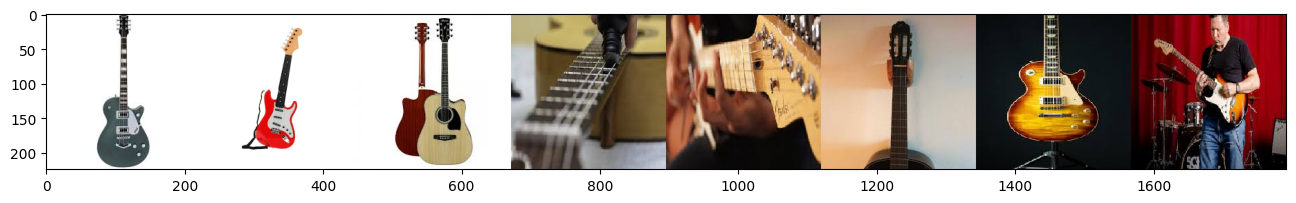

In [19]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### Construção da Rede Neural Base

* **Objetivo:** Estabelecer uma linha de base para comparar com uma rede treinada posteriormente por transferência de aprendizado.
* **Estrutura:**
  * 4 pares alternados de camadas convolucionais e de pooling máximo.
  * Camadas de dropout após cada dois pares conv/pooling para regularização.
  * Uma camada totalmente conectada com 256 neurônios.
  * Outra camada de [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).
  * Camada de saída softmax para classificação.
* **Função de perda:** Entropia cruzada categórica.
* **Otimizador:** [AdaDelta](https://arxiv.org/abs/1212.5701).
* **Justificativa:** O foco é em obter uma compreensão básica e não em otimização extrema.

### Análise da Rede
* **Visualização:** A função `model.summary()` será usada para obter um resumo detalhado da arquitetura da rede neural, incluindo o número de parâmetros, formato das camadas, etc.

1. Criando uma rede neural com aproximadamente 1,2 milhões de pesos e vieses (parâmetros).

In [20]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

2. Teinanando o modelo para 100 épocas com um tamanho de lote de 128.

In [21]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.4924 - loss: 0.7241 - val_accuracy: 0.4400 - val_loss: 0.7121
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.5398 - loss: 0.7030 - val_accuracy: 0.6533 - val_loss: 0.6871
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.6007 - loss: 0.6852 - val_accuracy: 0.6667 - val_loss: 0.6818
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6764 - loss: 0.6728 - val_accuracy: 0.6933 - val_loss: 0.6681
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6936 - loss: 0.6419 - val_accuracy: 0.6400 - val_loss: 0.6446
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.7078 - loss: 0.6006 - val_accuracy: 0.6267 - val_loss: 0.6684
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.7003 - loss: 0.5984 - val_accuracy: 0.6933 - val_loss: 0.6105
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7104 - loss: 0.5673 - val_accuracy: 0.7067 - val_loss: 0

3. Avaliando a perda de validação e a precisão da validação ao longo do tempo, e comparando os resultados.

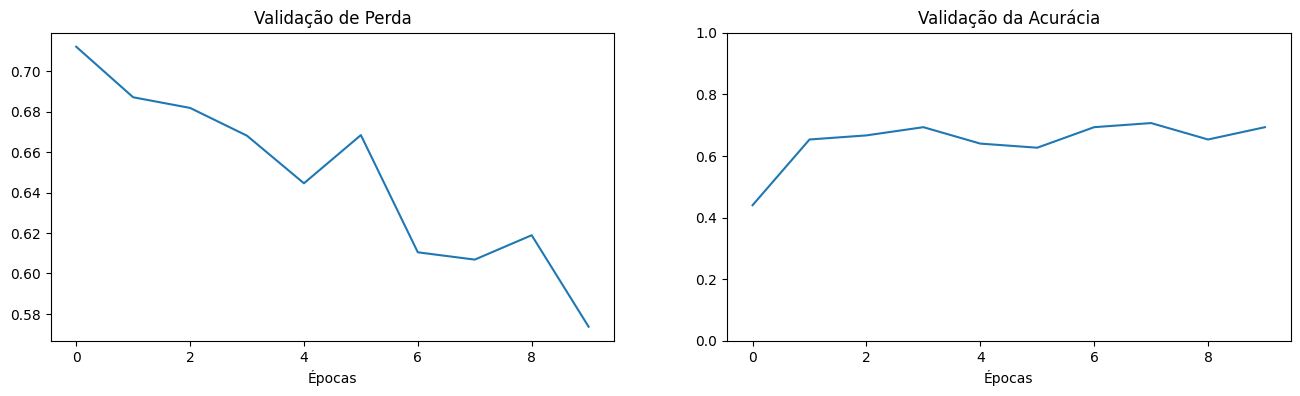

In [30]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("Validação de Perda")
ax.set_xlabel("Épocas")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("Validação da Acurácia")
ax2.set_xlabel("Épocas")
ax2.set_ylim(0, 1)

plt.show()

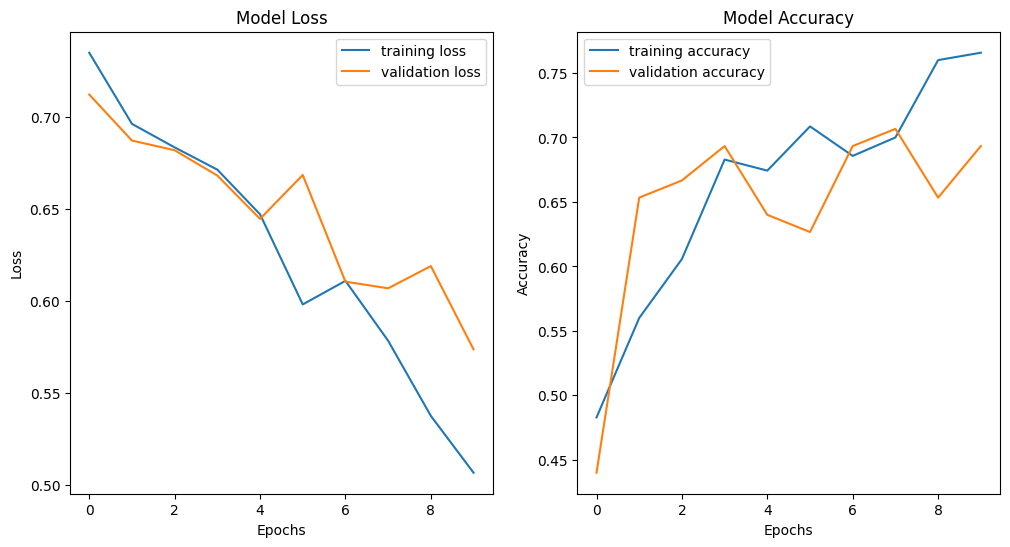

In [31]:
# Gráfico de precisão (accuracy)
fig = plt.figure(figsize=(12, 6))

# Loss (perda)
ax1 = fig.add_subplot(121)
ax1.plot(history.history["loss"], label="training loss")
ax1.plot(history.history["val_loss"], label="validation loss")
ax1.set_title("Model Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# Accuracy (acurácia)
ax2 = fig.add_subplot(122)
ax2.plot(history.history["accuracy"], label="training accuracy")
ax2.plot(history.history["val_accuracy"], label="validation accuracy")
ax2.set_title("Model Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

4. Observações e Análises pontuais ao modelo

A validação da perda no gráfico da Acurácia do Modelo começa a variar com 4 épocas, após uma crescente, acompanhando a validação da acurácia em torno de 65%. Isso sugere que nosso modelo começa a sobreajustar por volta dessa época, e o melhor desempenho teria sido alcançado se tivéssemos parado mais cedo por volta dessa época.

5. Avaliação Final com os seguintes resultados:

Alcançamos uma precisão de 60%, considerando o total de 500 imagens.

In [33]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Teste de Perda:', loss)
print('Teste da Acurácia:', accuracy)

Teste de Perda: 0.6763548254966736
Teste da Acurácia: 0.6000000238418579


# Transfer Learning começando com a rede existente

Vamos treinar um classificador de imagens em nosso pequeno conjunto de dados: começando com uma rede maior e já treinada.

1. Carregaremos o VGG16 do keras, que foi treinado no ImageNet e os pesos salvos online.

2. Depois que a rede for carregada, podemos inspecionar novamente as camadas com o método `summary()`.

In [34]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

### VGG16: Uma Rede Neural Convolucional

**Objetivo do VGG16:**
* Treinado para o conjunto de dados ImageNet com 1000 classes.
* Alcançou uma taxa de erro top-5 de 8.8%, o que significa que 91.2% das imagens foram classificadas corretamente entre as 5 principais previsões.

**Características do VGG16:**
* **Tamanho:** Muito maior que a rede construída anteriormente, com 13 camadas convolucionais e 2 camadas totalmente conectadas.
* **Parâmetros:** Mais de 138 milhões de parâmetros.
* **Complexidade:** Arquitetura profunda, com várias camadas e um grande número de parâmetros.

**Adaptação do VGG16 para Novos Conjuntos de Dados:**
* **Remoção da camada de saída:** A camada softmax original, projetada para 1000 classes do ImageNet, é substituída por uma nova camada softmax com o número de neurônios correspondente ao novo conjunto de dados (ex: 97 neurônios para o conjunto 101_ObjectCategories).
* **Criação de um novo modelo:** Em vez de modificar diretamente o modelo VGG16, cria-se um novo modelo com a mesma arquitetura até a penúltima camada, e adiciona-se a nova camada softmax.
* **Eficiência:** O Keras copia as camadas por referência, evitando duplicação desnecessária de dados e economizando memória.

3. Utilizando a classe keras `Model` para inicializar um novo modelo cuja camada de entrada é a mesma que VGG, mas cuja camada de saída é nossa nova camada softmax, chamada `new_classification_layer`.

In [36]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

 ## Praticando Tranfer Learning

 Na prática, vamos ao processo de aplicação de uma rede neural pré-treinada (VGG16) para um novo conjunto de dados, utilizando a técnica de transfer learning. A ideia central é aproveitar os conhecimentos adquiridos durante o treinamento em um grande conjunto de dados para acelerar o aprendizado em um conjunto de dados menor e mais específico.

In [38]:
# Treinando apenas a última camada e mantendo os pesos das demais fixas (congeladas)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Olhando para o resumo, vemos que a rede é idêntica ao modelo VGG que instanciamos anteriormente, exceto que a última camada, anteriormente um softmax de 1000 neurônios, foi substituída por um novo softmax de 97 neurônios. Além disso, ainda temos aproximadamente 134 milhões de pesos, mas agora a grande maioria deles são "parâmetros não treináveis" porque congelamos as camadas em que estão contidos. Agora temos apenas 397.000 parâmetros treináveis, o que na verdade é apenas um quarto do número de parâmetros necessários para treinar o primeiro modelo.

Como antes, seguimos em frente e treinamos o novo modelo, usando os mesmos hiperparâmetros (tamanho do lote e número de épocas) de antes, junto com o mesmo algoritmo de otimização. Também monitoramos seu histórico à medida que avançamos.

In [39]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 91s 27s/step - accuracy: 0.4977 - loss: 1.2552 - val_accuracy: 0.5600 - val_loss: 0.7422
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 650ms/step - accuracy: 0.4965 - loss: 0.7764 - val_accuracy: 0.4400 - val_loss: 0.9480
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step - accuracy: 0.5434 - loss: 0.7775 - val_accuracy: 0.5600 - val_loss: 0.6980
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step - accuracy: 0.4864 - loss: 0.7360 - val_accuracy: 0.6533 - val_loss: 0.6098
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 778ms/step - accuracy: 0.6976 - loss: 0.5935 - val_accuracy: 0.5867 - val_loss: 0.6351
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 641ms/step - accuracy: 0.7090 - loss: 0.5545 - val_accuracy: 0.7333 - val_loss: 0.5697
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 787ms/step - accuracy: 0.7413 - loss: 0.5675 - val_accuracy: 0.7200 - val_loss: 0.5498
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 796ms/step - accuracy: 0.7826 - loss: 0.5215 - val_accuracy: 0.7067 - val_loss: 

Nossa precisão de validação oscila perto de 80% no final, o que é mais de 30% de melhoria na rede original treinada do zero (o que significa que fazemos a previsão errada em 20% das amostras, em vez de 50%).

Vale a pena notar também que esta rede na verdade treina um pouco mais rápido do que a rede original, apesar de ter mais de 100 vezes mais parâmetros! Isso ocorre porque congelar os pesos nega a necessidade de retropropagação por todas essas camadas, economizando tempo de execução.

Vamos plotar a perda de validação e a precisão novamente, desta vez comparando o modelo original treinado do zero (em azul) e o novo modelo aprendido por transferência em verde.

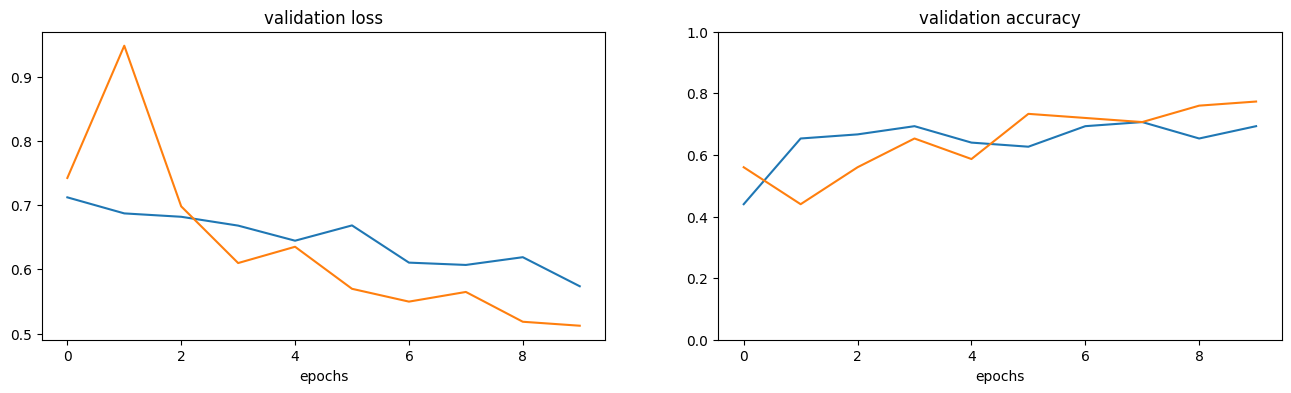

In [49]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

<bound method _AxesBase.set_ylabel of <Axes: title={'center': 'Validation Accuracy'}, xlabel='Epochs'>>

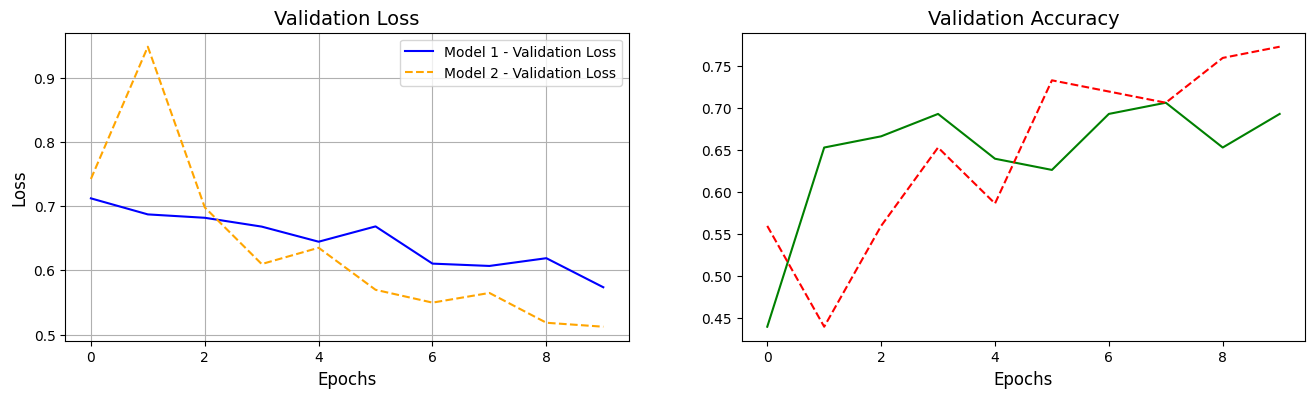

In [50]:
# Melhorando o gráfico com legendas e labels
fig = plt.figure(figsize=(16, 4))

# Gráfico da Perda de Validação
ax1 = fig.add_subplot(121)
ax1.plot(history.history["val_loss"], label="Model 1 - Validation Loss", color="blue", linestyle="-")
ax1.plot(history2.history["val_loss"], label="Model 2 - Validation Loss", color="orange", linestyle="--")
ax1.set_title("Validation Loss", fontsize=14)
ax1.set_xlabel("Epochs", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.legend(loc="upper right", fontsize=10)
ax1.grid(True)

# Gráfico da Acurácia de Validação
ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"], label="Model 1 - Validation Accuracy", color="green", linestyle="-")
ax2.plot(history2.history["val_accuracy"], label="Model 2 - Validation Accuracy", color="red", linestyle="--")
ax2.set_title("Validation Accuracy", fontsize=14)
ax2.set_xlabel("Epochs", fontsize=12)
ax2.set_ylabel


Observe que, enquanto o modelo original começou a sobreajustar em torno da época 16, o novo modelo continuou a diminuir lentamente sua perda ao longo do tempo e provavelmente teria melhorado sua precisão ligeiramente com mais iterações. O novo modelo chegou a aproximadamente 80% de precisão top-1 (no conjunto de validação) e continuou a melhorar lentamente por 100 épocas.

É possível que pudéssemos ter melhorado o modelo original com melhor regularização ou mais abandono, mas certamente não teríamos compensado a melhoria de >30% na precisão.

Novamente, fazemos uma validação final no conjunto de teste.

In [44]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.48589786887168884
Test accuracy: 0.8266666531562805


To predict a new image, simply run the following code to get the probabilities for each class.

In [45]:
img, x = get_image('/content/drive/MyDrive/Colab Notebooks/transfer-learning-python/dataset/violao/images.png')
probabilities = model_new.predict([x])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


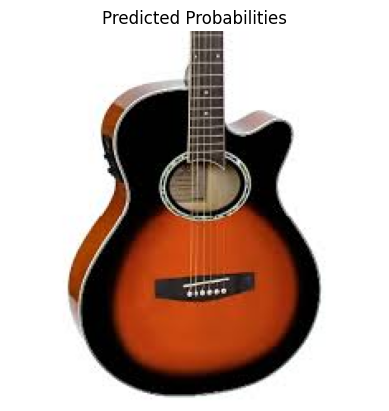

Probabilities: [[0.00216537 0.9978346 ]]


In [46]:
# Substituir o caminho para a imagem do seu projeto
img, x = get_image('/content/drive/MyDrive/Colab Notebooks/transfer-learning-python/dataset/violao/images.jpeg')  # Caminho para uma imagem de violão
probabilities = model_new.predict([x])

# Exibir a imagem e as probabilidades previstas
plt.imshow(img)
plt.axis("off")
plt.title("Predicted Probabilities")
plt.show()

print("Probabilities:", probabilities)


## Consideração Finais ao Modelo

**Desempenho do modelo:**
* A precisão de 82% é considerada boa, especialmente considerando o número de classes e o tamanho do conjunto de dados.
* O desempenho é inferior ao VGG16 original, mas superior ao modelo inicial, que obteve 60% de precisão (acurácia).

**Possíveis melhorias:**
* **Aumento de dados:** Criar variações das imagens de treinamento para aumentar o tamanho do conjunto e melhorar a generalização do modelo.
* **Hiperparâmetros:** Experimentar diferentes otimizadores, taxas de aprendizado, regularização e outras configurações.
* **Treinamento mais longo:** Permitir que o modelo aprenda padrões mais complexos.

**Referência:**
* **Blog do Keras:** Apresenta um exemplo mais avançado de *transfer learning* com aumento de dados para um conjunto de dados menor.

**Conclusão:**
O modelo apresentou um bom desempenho, mas há potencial para melhorias através de técnicas como aumento de dados e ajuste de hiperparâmetros.


## Agora é sua vez de se divertir e aplicar o modelo!

A seguir, você pode carregar uma imagem válida, de violão ou guitarra, e aplicar o presente modelo de classificação com redes neurais.

Boa diversão!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


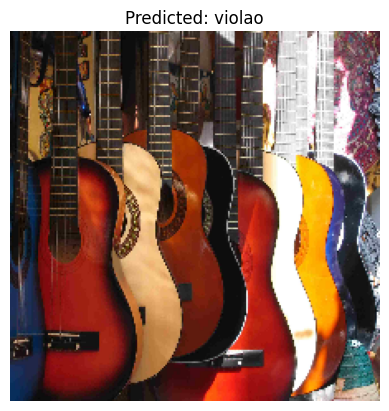

Probabilities: [[0.99393976 0.00606023]]
Predicted Class: violao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


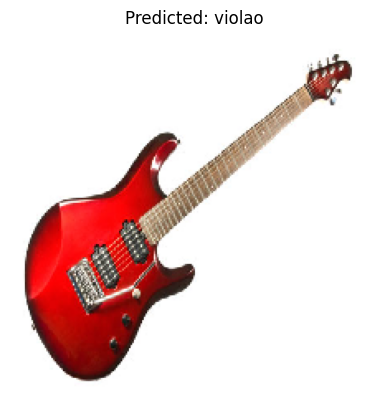

Probabilities: [[0.9808648  0.01913518]]
Predicted Class: violao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


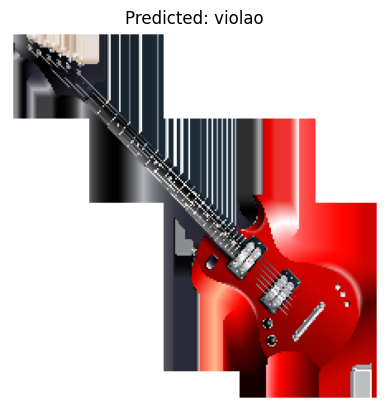

Probabilities: [[0.99644995 0.00355004]]
Predicted Class: violao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


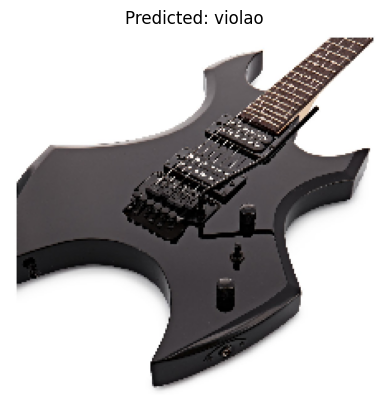

Probabilities: [[0.9953674  0.00463264]]
Predicted Class: violao


In [47]:
def classify_image_external(model, image_path, class_labels):
    """
    Classifica uma imagem utilizando o modelo treinado.

    Args:
        model: O modelo treinado para a classificação.
        image_path: Caminho ou objeto da imagem a ser classificada.
        class_labels: Lista com os nomes das classes (ex: ['violao', 'guitarra']).

    Returns:
        None. Exibe a imagem e a classe prevista.
    """
    # Carregar e preprocessar a imagem
    img, x = get_image(image_path)
    probabilities = model.predict([x])

    # Determinar a classe com maior probabilidade
    predicted_class = class_labels[np.argmax(probabilities)]

    # Exibir a imagem e o resultado da classificação
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predição: {predicted_class}")
    plt.show()

    print(f"Probabilidade: {probabilities}")
    print(f"Classe predita: {predicted_class}")

# Lista de classes do modelo
class_labels = ["violao", "guitarra"]

# Função para processar imagem local
def upload_image(change):
    uploaded_file = next(iter(upload_widget.value.values()))
    content = uploaded_file['content']

    # Salvar a imagem para processamento
    with open("temp_image.jpg", "wb") as f:
        f.write(content)
    classify_image_external(model_new, "temp_image.jpg", class_labels)

# Função para processar imagem de URL
def classify_image_from_url(url):
    try:
        # Fazer requisição HTTP para a URL
        response = requests.get(url)

        # Verificar se o conteúdo retornado é válido
        if response.status_code == 200 and "image" in response.headers["Content-Type"]:
            # Abrir a imagem diretamente
            img = Image.open(BytesIO(response.content))
            img.save("temp_url_image.jpg")  # Salvar a imagem temporariamente
            classify_image_external(model_new, "temp_url_image.jpg", class_labels)
        else:
            print("Erro: O link fornecido não retorna uma imagem válida.")
    except Exception as e:
        print(f"Erro ao carregar a imagem da URL: {e}")

# Widgets para interação
upload_widget = FileUpload(accept='image/*', multiple=False)
url_widget = widgets.Text(
    value='',
    placeholder='Digite a URL da imagem',
    description='URL:',
    layout=widgets.Layout(width='50%')
)
button_url = widgets.Button(description="Classificar Imagem URL")
output = widgets.Output()

def on_button_url_click(b):
    with output:
        output.clear_output()
        classify_image_from_url(url_widget.value)

# Conectar os widgets às funções
upload_widget.observe(upload_image, names='value')
button_url.on_click(on_button_url_click)

# Exibir os widgets
display(widgets.VBox([
    widgets.HTML("<h3>Selecione uma Imagem:</h3>"),
    upload_widget,
    widgets.HTML("<h3>Ou forneça uma URL:</h3>"),
    url_widget,
    button_url,
    output
]))
